Run this line to install `RobustiPy` from GitHub.

In [ ]:
%pip install git+https://github.com/robustipy/robustipy.git

In [1]:
import os
import numpy as np
from robustipy.models import OLSRobust
import pandas as pd
import matplotlib.pyplot as plt

# Data generation
Let's generated some data based on some covariance values and totally made-up coeficients.

This code generates synthetic data for 1000 unique groups, each with 10 observations. It creates continuous beta coefficients for each group from a normal distribution, simulates the features and dependent variable with added noise, and combines them into a DataFrame. The result is a dataset with significant variation within and between groups

In [44]:
import numpy as np
import pandas as pd

# Define the mean and standard deviation for the continuous range of betas
beta_mean = [0.9, 0.4, -0.7, -0.1, 0.2]
beta_std = 2

cov_matrix = np.array([[1, 0.7, 0.5, 0.7, 0.1],
                       [0.7, 1, 0.5, 0.3, 0.2],
                       [0.5, 0.5, 1, 0.4, 0.2],
                       [0.7, 0.3, 0.4, 1, 0.6],
                       [0.1, 0.2, 0.2, 0.6, 1]])

num_samples_per_group = 10 
num_groups = 1000 
total_samples = num_samples_per_group * num_groups
mean_vector = np.zeros(5) 

X_list = []
Y_list = []
group_list = []

all_group_ids = range(1, num_groups + 1)

for group_id in all_group_ids:
    # Generate beta coefficients for each group from a normal distribution
    beta = np.random.normal(beta_mean, beta_std, size=len(beta_mean))
    X = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=num_samples_per_group)
    # Add more variation within the group by adding random noise to the features
    X += np.random.normal(0, 3, X.shape)
    X_i = np.column_stack((np.ones(num_samples_per_group), X[:, 0:4]))
    # Increase the standard deviation of the errors to introduce more variation within the group
    errors = np.random.normal(loc=0.0, scale=10.0, size=num_samples_per_group)
    Y = np.dot(X_i, beta) + errors
    X_list.append(X)
    Y_list.append(Y)
    group_list.extend([group_id] * num_samples_per_group)

X_combined = np.vstack(X_list)
Y_combined = np.concatenate(Y_list)
np_data = np.column_stack((Y_combined, X_combined))

data = pd.DataFrame(np_data, columns=['y', 'x1', 'z1', 'z2', 'z3', 'z4'])
data['group'] = group_list

data


,y,x1,z1,z2,z3,z4,group
0,-8.426651,4.941504,5.533894,-3.457763,-3.598944,4.831154,1
1,-9.963846,1.855892,-0.073829,4.257883,3.187320,3.066636,1
2,12.244243,1.756494,-0.049982,-1.056185,-3.784142,5.561778,1
3,20.561216,-6.584864,1.428330,-3.308471,-3.968644,-7.372979,1
4,14.502802,2.354812,-1.600820,0.871362,-0.015371,3.112361,1
5,-11.130902,-1.924570,-6.489251,0.878039,-0.778232,-1.884655,1
6,0.716350,-2.565091,0.608675,7.415736,0.268836,-0.004571,1
7,-4.943085,-0.634545,-5.692576,2.427842,-5.551457,-2.874706,1
8,8.660004,-0.932253,-0.503725,-1.850767,-5.571067,-2.339590,1
9,9.691147,0.599279,-4.697821,-4.488788,-1.366311,2.298522,1


Let's plot the correlation of our variables.

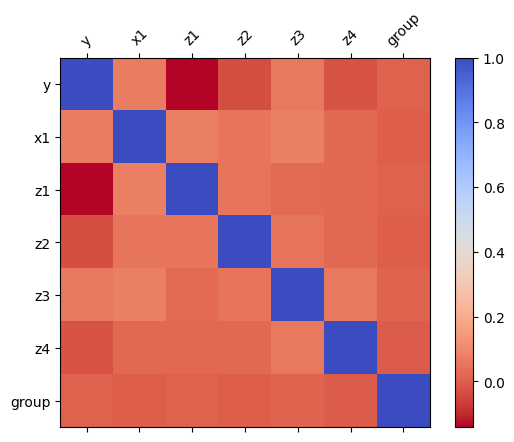

In [45]:
labels = data.columns
fig, ax = plt.subplots()
cax = ax.matshow(data.corr(), cmap='coolwarm_r')

fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(rotation=45)

plt.show()

## Testing RobustiPy with this simulated data

In this case, in whihc we have a grouping variable, the only change we need to do to our code is to provide the name of the grouoping variables as an argument for the `fit` function.

Output()

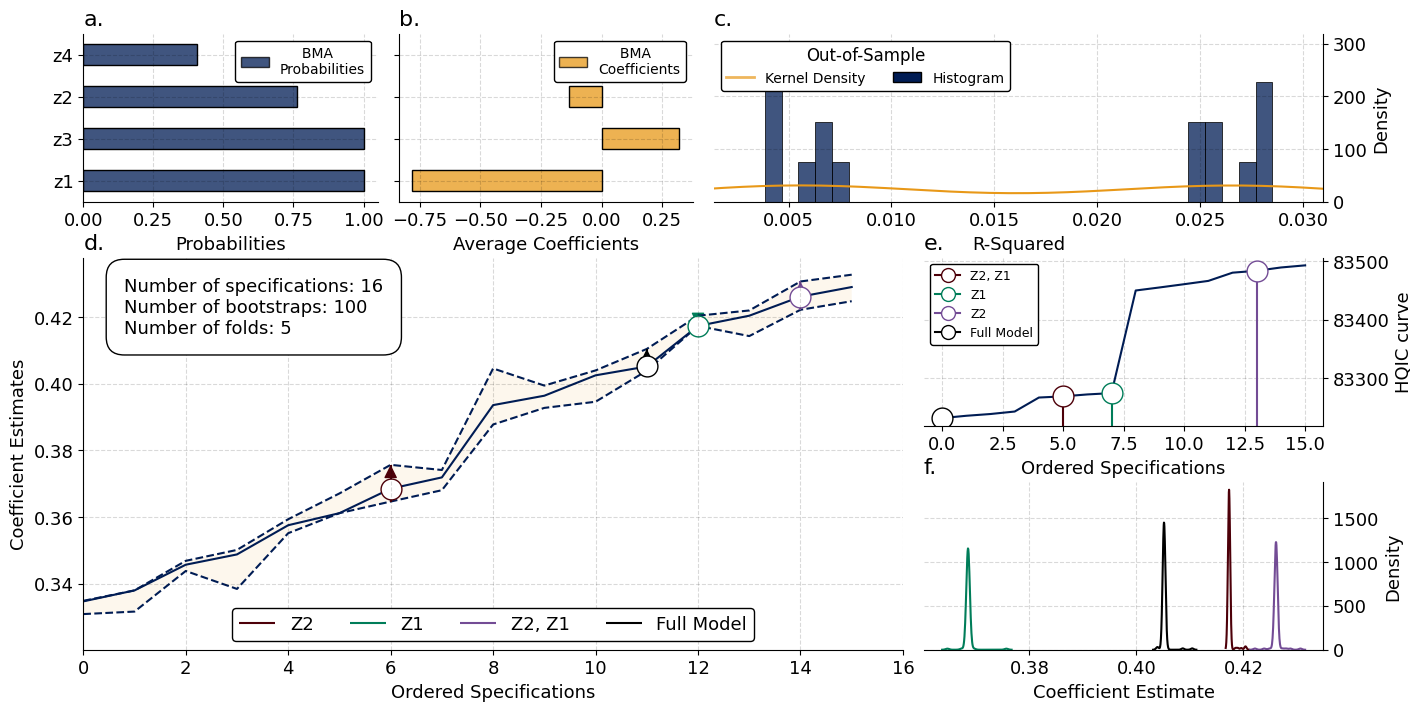

In [46]:
y = ['y'] # input names must always be enclosed in a list.
x = ['x1']
c= ['z1', 'z2', 'z3', 'z4']
group = 'group'

sim1 = OLSRobust(y=y, x=x, data=data)
sim1.fit(controls=c, group=group, draws=100)
sim1_results = sim1.get_results()

sim1_results.plot(specs=[['z1', 'z2'], ['z1'], ['z2']], ic='hqic', figsize=(16, 8))

Finally lets take a look at the summary of our model.

In [37]:
sim1_results.summary()

1. Model Summary
Model: OLS Robust
Dependent variable: y
Independent variable: x1
Number of possible controls: 4
Number of draws: 100
Number of folds: 5
Number of specifications: 16
2.Model Robustness Metrics
2.1 Inference Metrics
------------------------------------------------------------------------------------------------------------
Mean beta: 13.95
Significant portion of beta: 0.00
Positive portion of beta: 0.75
Positive and Significant portion of beta: 0.00
Min AIC: 231663.40039294257, Specs: ['z2', 'z4', 'z1', 'z3']
Min BIC: 211682.53468924898, Specs: []
Min HQIC: 211672.99531573048, Specs: []
------------------------------------------------------------------------------------------------------------
2.2 Averaged Out-Of-Sample Metrics (r-squared)
------------------------------------------------------------------------------------------------------------
Max: -0.0005838558070617062, Specs: [] 
Min: -0.001905325582497852, Specs: ['z2', 'z4', 'z1', 'z3'] 
Mean: -0.00
Median: -0.00